Soroosh Noorzad<br/>
99205372<br/>
Winter of 1400

In [1]:
import tensorflow as tf

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, Conv1D, GRU, Bidirectional, MaxPool1D
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import os
import time
import pickle
import logging
import itertools
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Mount:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Download:

In [3]:
def downloader_to_gdrive(link, base_path, file_name, zip, chunk_size = 1000):
  path = base_path + file_name
  import os
  isdir = os.path.isdir(path[:-4])
  if isdir:
    print(file_name[:-4], "folder already exists! Download skipped...")
  else:
    isFile = os.path.isfile(path)
    if isFile:
      print(file_name, "already exists! Download skipped...")
    else:
      import requests
      r = requests.get(link, stream = True)
      # 1 MB = 1024 * 1024 byte
      CS = chunk_size*1024*1024
      with open(path, "wb") as file: 
        print(file_name, "download started.")
        for i, block in enumerate(r.iter_content(chunk_size = CS)):
          print(".", end = "")
          # print((i+1)*chunk_size,"MB downloaded...")
          if block:
            file.write(block)
        print("\n" + file_name, "download finished.")
    if zip:
      print("Extracting started...")
      import zipfile
      with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall(path[:-4])

base_path = "/content/drive/MyDrive/"

SDS_name = "sen.zip"
dataset_path = base_path + SDS_name
SDS_link =  "http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip"
downloader_to_gdrive(SDS_link, base_path, SDS_name, True, 1000)

GLOVE_name = "glove42.zip"
glove_path = base_path + GLOVE_name
GLOVE_link = "http://nlp.stanford.edu/data/glove.42B.300d.zip"
downloader_to_gdrive(GLOVE_link, base_path, GLOVE_name, True, 1000)

sen folder already exists! Download skipped...
glove42.zip download started.
..
glove42.zip download finished.
Extracting started...


Preprocess:

2022-01-16 17:29:38,621 : INFO : NumExpr defaulting to 2 threads.


train dataset size: 1600000
test  dataset size: 359 



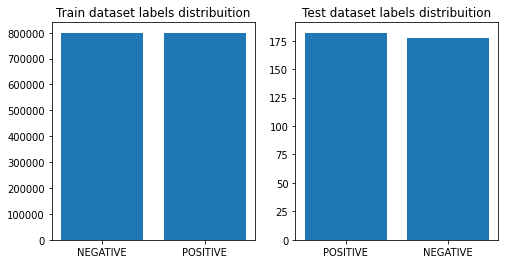

In [4]:
# %%time
# READ DATASET:

dataset_utilize_percent = 1

DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

filenames = os.listdir(dataset_path[:-4])
te_df = pd.read_csv(dataset_path[:-4] + "/" + filenames[0], encoding =DATASET_ENCODING , names=DATASET_COLUMNS)
te_df = te_df.drop(['ids', 'date', 'flag', 'user'], axis = 1)
te_df = te_df[te_df.target != 2]
tr_df = pd.read_csv(dataset_path[:-4] + "/" + filenames[1], encoding =DATASET_ENCODING , names=DATASET_COLUMNS)
tr_df = tr_df.drop(['ids', 'date', 'flag', 'user'], axis = 1)

drop_indices = np.random.choice(tr_df.index, int((1-dataset_utilize_percent)*len(tr_df)), replace=False)
tr_df = tr_df.drop(drop_indices)

print("train dataset size:", len(tr_df))
print("test  dataset size:", len(te_df), "\n")


# Cleaning Section:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
def preprocess(text, stem=False):
  # Replace or remove links, mentions and special characters:
  # Remove mentions:
  TEXT_CLEANING_RE = "@\S+"
  # Rmove links:
  TEXT_CLEANING_RE += "|https?:\S+|http?:\S"
  # Remove any chars EXCEPT A-Z & a-z & 0-9:
  TEXT_CLEANING_RE += "|[^A-Za-z0-9]+"
  text = re.sub(TEXT_CLEANING_RE, " ", text.lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
        if stem:
            tokens.append(stemmer.stem(token))
        else:
            tokens.append(token)
  return " ".join(tokens)

# print("Row 1237, BEFORE CLEANING:", tr_df['text'][1237])
tr_df.text = tr_df.text.apply(lambda x: preprocess(x))
te_df.text = te_df.text.apply(lambda x: preprocess(x))
# print("Row 1237, AFTER  CLEANING:", tr_df['text'][1237], "\n")


# Mapper Section
def dataframe_mapper(df, col_name, from_l, to_l):
  for i in range(len(from_l)):
    df.loc[df[col_name] == from_l[i], col_name] = to_l[i]

# (0 = negative, 2 = neutral, 4 = positive)
target_labels = ["NEGATIVE", "POSITIVE"]

dataframe_mapper(tr_df, 'target', [0, 4], target_labels)
dataframe_mapper(te_df, 'target', [0, 4], target_labels)

train_target_cnt = Counter(tr_df.target)
plt.figure(1, figsize=(8,4))
plt.subplot(121)
plt.bar(train_target_cnt.keys(), train_target_cnt.values())
plt.title("Train dataset labels distribuition")
plt.subplot(122)
test_target_cnt = Counter(te_df.target)
plt.bar(test_target_cnt.keys(), test_target_cnt.values())
plt.title("Test dataset labels distribuition")
plt.show()

dataframe_mapper(tr_df, 'target', target_labels, [0, 1])
dataframe_mapper(te_df, 'target', target_labels, [0, 1])

In [5]:
%%time

# load embedding as a dict
def load_glove_model(File):
  print("Loading Glove Model")
  # create a map of words to vectors
  glove_model = {}
  # load embedding into memory, skip first line
  with open(File,'r') as f:
    for line in f:
      split_line = line.split()
      # key is string word, value is numpy array for vector
      word = split_line[0]
      embedding = np.array(split_line[1:], dtype=np.float64)
      glove_model[word] = embedding
  print(f"{len(glove_model)} words loaded!", "\n")
  return glove_model


# load embedding from file
filenames = os.listdir(glove_path[:-4])
glove_model = load_glove_model(glove_path[:-4] + "/" + filenames[0])

Loading Glove Model
1917494 words loaded! 

CPU times: user 1min 59s, sys: 5.17 s, total: 2min 5s
Wall time: 2min 6s


In [6]:
# %%time
# create a weight matrix for the Embedding layer from a loaded embedding
def get_weight_matrix(embedding, vocab, embedding_dim, vocab_size):
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, embedding_dim))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        vector = embedding.get(word)
        if vector is not None:
            weight_matrix[i] = vector
    return weight_matrix

# ######################################################################
# create a tokenizer
tokenizer = Tokenizer()
# fit the tokenizer in the train text
tokenizer.fit_on_texts(tr_df.text)

# saving tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol = pickle.HIGHEST_PROTOCOL)

# ######################################################################
class_count = 2
# create a label encoder
encoder = LabelEncoder()
# enconde labels (0 or 1) in train data
encoder.fit(tr_df.target.to_list())
# transform labels in y_train and y_test data to the encoded ones
y_train = encoder.transform(tr_df.target.to_list())
y_test = encoder.transform(te_df.target.to_list())
# reshape y_train and y_test data
y_train = y_train.reshape(-1, 1)
y_train_one_hot = tf.keras.utils.to_categorical(y_train, class_count)
y_test = y_test.reshape(-1, 1)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, class_count)

# get max length of the train data
max_length = max([len(s.split()) for s in tr_df.text])
# pad sequences in x_train data set to the max length
x_train = pad_sequences(tokenizer.texts_to_sequences(tr_df.text), maxlen = max_length)
# pad sequences in x_test data set to the max length
x_test = pad_sequences(tokenizer.texts_to_sequences(te_df.text), maxlen = max_length)

print("x_train shape: ", x_train.shape)
print("x_test shape: ", x_test.shape, "\n")
print("y_train shape:", y_train_one_hot.shape)
print("y_test shape:", y_test_one_hot.shape, "\n")

# ######################################################################
# vocab contains the index for each word
vocab = tokenizer.word_index
# vocab_size: total number of words in our vocabulary, plus one for unknown words
voc_size = len(vocab) + 1
# embedding dimensions
em_dim = 300
# get vectors in the right order
embedding_matrix = get_weight_matrix(glove_model, vocab, em_dim, voc_size)

# create the embedding layer
embedding_layer = Embedding(voc_size, em_dim, weights = [embedding_matrix], input_length = max_length, trainable = False)

print("Vocab size (Total words): ", voc_size)
print("Max text length: ", max_length)
print("Embedding dim: ", em_dim, "\n")

x_train shape:  (1600000, 50)
x_test shape:  (359, 50) 

y_train shape: (1600000, 2)
y_test shape: (359, 2) 

Vocab size (Total words):  335508
Max text length:  50
Embedding dim:  300 



# Part A

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 31, 300)           5610300   
                                                                 
 dense (Dense)               (None, 31, 300)           90300     
                                                                 
 dropout (Dropout)           (None, 31, 300)           0         
                                                                 
 lstm (LSTM)                 (None, 150)               270600    
                                                                 
 dense_1 (Dense)             (None, 2)                 302       
                                                                 
Total params: 5,971,502
Trainable params: 361,202
Non-trainable params: 5,610,300
_________________________________________________________________
None
Epoch 1/10
2/2 [===================

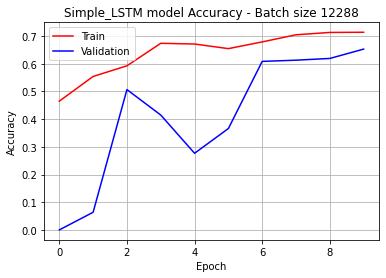


Plot the Accuracy Curves


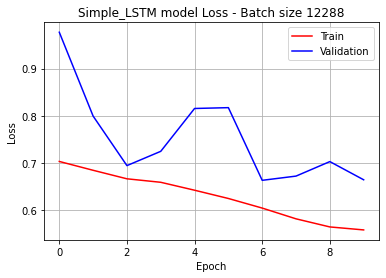

Tweet                  | Label      | Score
-------------------------------------------
peace                  | Positive   | 0.80
war                    | Negative   | 0.79
love                   | Positive   | 0.92
hate                   | Negative   | 0.92
Be together people!    | Positive   | 0.54
They killed everybody! | Negative   | 0.91

Confusion Matrix for Test dataset:


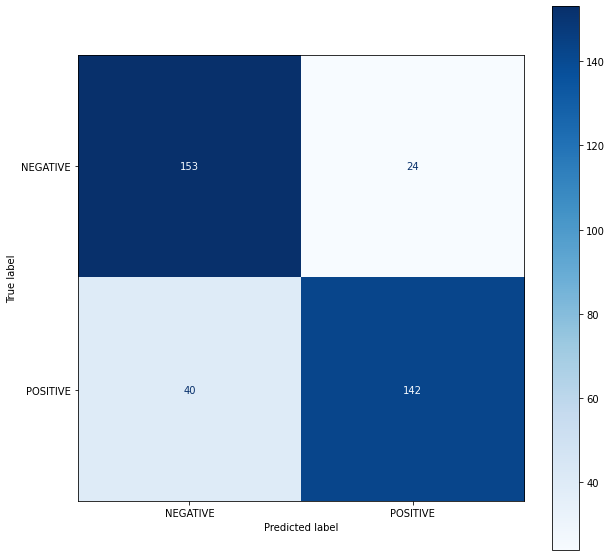

CPU times: user 6min 26s, sys: 49.1 s, total: 7min 15s
Wall time: 4min 27s


In [ ]:
%%time

bidirectional_lstm = False
BATCH_SIZE = 12 * 1024
EPOCHS = 10

# define model
model = Sequential()
model.add(embedding_layer)
model.add(Dense(em_dim, activation = "relu"))
model.add(Dropout(0.2))
if bidirectional_lstm:
  model.add(Bidirectional(LSTM(150, dropout = 0.2)))
else:
  model.add(LSTM(150, dropout = 0.2))
model.add(Dense(class_count, activation = "softmax"))

opt_type = 'adam'
if opt_type=='adam':
    opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
else:
    # opt_type=='sgd'
    opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, name=opt_type.upper())

model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
print(model.summary())

# train model
history = model.fit(x_train, y_train_one_hot, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_split = 0.1, shuffle=True, verbose = 1)

print("\nEvaluate model:")
score = model.evaluate(x_test, y_test_one_hot, batch_size = BATCH_SIZE)
print("Test loss:", score[0])
print("Test accuracy:", score[1], "\n")

# save model
model.save('model_final.h5')

# plotting model performance
def model_plotter(model_history, metric, model_name, b_s):
    plt.figure()
    plt.plot(model_history.history[metric.lower()],'r')
    plt.plot(model_history.history['val_'+metric.lower()],'b')
    plt.title(model_name + ' model ' + metric.capitalize() + " - Batch size " + str(b_s))
    plt.ylabel(metric.capitalize())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.grid()
    plt.savefig(model_name + "_" + metric.lower() + "_" + str(b_s) + ".png")
    plt.show()

print("\nPlot the Accuracy Curves")
model_plotter(history, 'accuracy', "Simple_LSTM", BATCH_SIZE)

print("\nPlot the Accuracy Curves")
model_plotter(history, 'loss', "Simple_LSTM", BATCH_SIZE)

# decode score prediction from the model, to be 0 or 1
def decode_prediction(prediction):
  if prediction <= 0.5:
    return 'Negative'
  else:
    return 'Positive'

# load model
model = load_model('model_final.h5')
# loading tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

def query_model(tweets):
  tml = len(max(tweets, key=len))
  str = "{} | {} | {}".format(f'{"Tweet": <{tml}}', f'{"Label": <{10}}', f'{"Score": <{5}}')
  print(str)
  print("-"*len(str))
  for tweet in tweets:
    # clean query text
    input_text = preprocess(tweet)
    # tokenize and pad query test as in training
    input_text = pad_sequences(tokenizer.texts_to_sequences([input_text]), maxlen = max_length)
    # get model prediction
    prediction = model.predict([input_text])[0]
    y_pred = np.argmax(prediction)
    print("{} | {} | {:.2f}".format(f'{tweet: <{tml}}', f'{decode_prediction(y_pred): <{10}}', prediction[y_pred]))

# Example: Test model with a new query
query_model(["peace", "war", "love", "hate", "Be together people!", "They killed everybody!"])

# Confusion Matrix
y_pred_softmax = model.predict(x_test)
y_pred = [np.argmax(y) for y in y_pred_softmax]
cm = confusion_matrix(y_test, y_pred)
plt.rcParams["figure.figsize"] = (10,10)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_labels)
disp.plot(cmap=plt.cm.Blues)
print("\nConfusion Matrix for Test dataset:")
plt.show()

# Part B

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 300)           100652400 
                                                                 
 dense_6 (Dense)             (None, 50, 300)           90300     
                                                                 
 dropout_3 (Dropout)         (None, 50, 300)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 300)              541200    
 l)                                                              
                                                                 
 dense_7 (Dense)             (None, 2)                 602       
                                                                 
Total params: 101,284,502
Trainable params: 632,102
Non-trainable params: 100,652,400
__________________________________

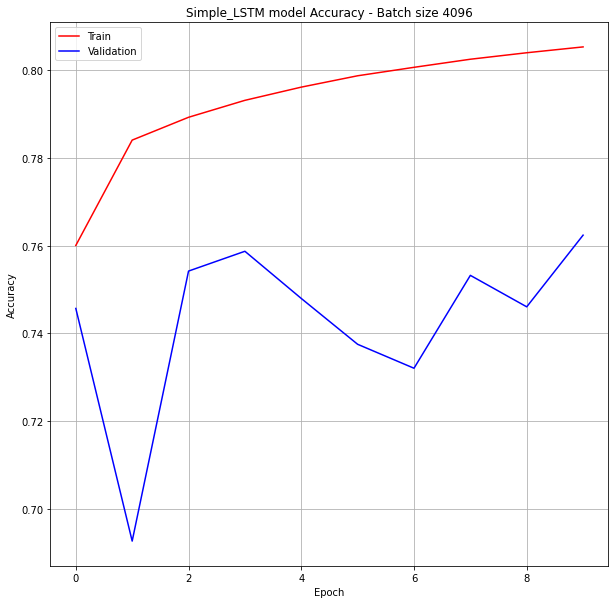


Plot the Accuracy Curves


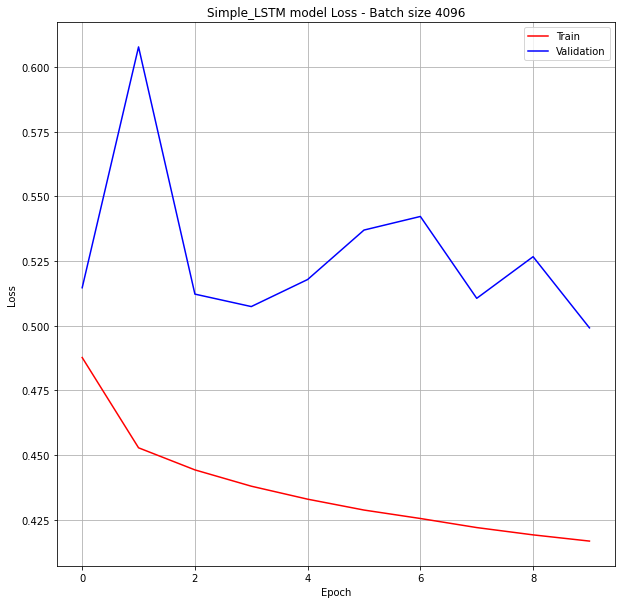

Tweet                  | Label      | Score
-------------------------------------------
peace                  | Positive   | 0.86
war                    | Negative   | 0.86
love                   | Positive   | 0.96
hate                   | Negative   | 0.99
Be together people!    | Positive   | 0.94
They killed everybody! | Negative   | 0.99

Confusion Matrix for Test dataset:


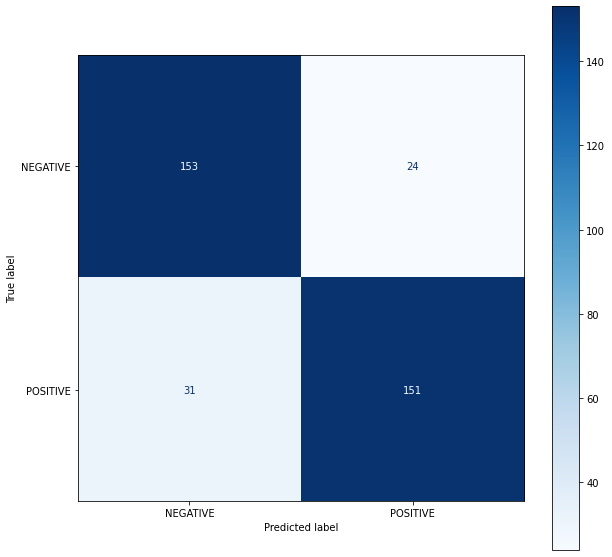

CPU times: user 29min 2s, sys: 26.9 s, total: 29min 29s
Wall time: 43min 1s


In [ ]:
%%time

bidirectional_lstm = True
BATCH_SIZE = 4 * 1024
EPOCHS = 10

# define model
model = Sequential()
model.add(embedding_layer)
model.add(Dense(em_dim, activation = "relu"))
model.add(Dropout(0.2))
if bidirectional_lstm:
  model.add(Bidirectional(LSTM(150, dropout = 0.2)))
else:
  model.add(LSTM(150, dropout = 0.2))
model.add(Dense(class_count, activation = "softmax"))

opt_type = 'adam'
if opt_type=='adam':
    opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
else:
    # opt_type=='sgd'
    opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, name=opt_type.upper())

model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
print(model.summary())

# train model
history = model.fit(x_train, y_train_one_hot, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_split = 0.1, shuffle=True, verbose = 1)

print("\nEvaluate model:")
score = model.evaluate(x_test, y_test_one_hot, batch_size = BATCH_SIZE)
print("Test loss:", score[0])
print("Test accuracy:", score[1], "\n")

# save model
model.save('model_final.h5')

# plotting model performance
def model_plotter(model_history, metric, model_name, b_s):
    plt.figure()
    plt.plot(model_history.history[metric.lower()],'r')
    plt.plot(model_history.history['val_'+metric.lower()],'b')
    plt.title(model_name + ' model ' + metric.capitalize() + " - Batch size " + str(b_s))
    plt.ylabel(metric.capitalize())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.grid()
    plt.savefig(model_name + "_" + metric.lower() + "_" + str(b_s) + ".png")
    plt.show()

print("\nPlot the Accuracy Curves")
model_plotter(history, 'accuracy', "Bidirectional_LSTM", BATCH_SIZE)

print("\nPlot the Accuracy Curves")
model_plotter(history, 'loss', "Bidirectional_LSTM", BATCH_SIZE)

# decode score prediction from the model, to be 0 or 1
def decode_prediction(prediction):
  if prediction <= 0.5:
    return 'Negative'
  else:
    return 'Positive'

# load model
model = load_model('model_final.h5')
# loading tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

def query_model(tweets):
  tml = len(max(tweets, key=len))
  str = "{} | {} | {}".format(f'{"Tweet": <{tml}}', f'{"Label": <{10}}', f'{"Score": <{5}}')
  print(str)
  print("-"*len(str))
  for tweet in tweets:
    # clean query text
    input_text = preprocess(tweet)
    # tokenize and pad query test as in training
    input_text = pad_sequences(tokenizer.texts_to_sequences([input_text]), maxlen = max_length)
    # get model prediction
    prediction = model.predict([input_text])[0]
    y_pred = np.argmax(prediction)
    print("{} | {} | {:.2f}".format(f'{tweet: <{tml}}', f'{decode_prediction(y_pred): <{10}}', prediction[y_pred]))

# Example: Test model with a new query
query_model(["peace", "war", "love", "hate", "Be together people!", "They killed everybody!"])

# Confusion Matrix
y_pred_softmax = model.predict(x_test)
y_pred = [np.argmax(y) for y in y_pred_softmax]
cm = confusion_matrix(y_test, y_pred)
plt.rcParams["figure.figsize"] = (10,10)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_labels)
disp.plot(cmap=plt.cm.Blues)
print("\nConfusion Matrix for Test dataset:")
plt.show()

# Part C

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 300)           100652400 
                                                                 
 dropout (Dropout)           (None, 50, 300)           0         
                                                                 
 dense (Dense)               (None, 50, 300)           90300     
                                                                 
 dropout_1 (Dropout)         (None, 50, 300)           0         
                                                                 
 lstm (LSTM)                 (None, 50, 64)            93440     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 25, 64)           0         
 )                                                               
                                                        

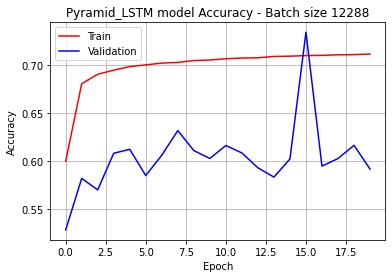


Plot the Accuracy Curves


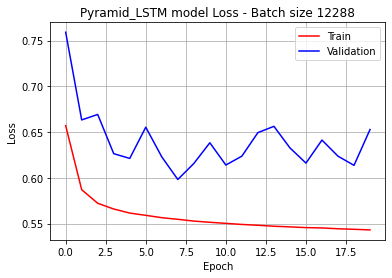

Tweet                  | Label      | Score
-------------------------------------------
peace                  | Negative   | 0.53
war                    | Negative   | 0.53
love                   | Negative   | 0.53
hate                   | Negative   | 0.53
Be together people!    | Negative   | 0.53
They killed everybody! | Negative   | 0.53

Confusion Matrix for Test dataset:


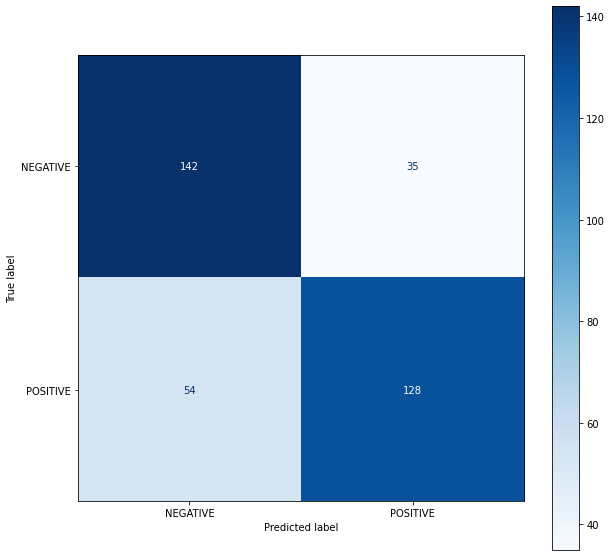

In [7]:
bidirectional_lstm = False
BATCH_SIZE = 12 * 1024
EPOCHS = 20


# define model
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.2))
model.add(Dense(em_dim, activation = "relu"))
model.add(Dropout(0.2))
model.add(LSTM(64, dropout=0.2, return_sequences=True))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='valid'))
model.add(LSTM(32, dropout=0.2, return_sequences=True))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='valid'))
model.add(LSTM(16, dropout=0.2, return_sequences=True))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='valid'))
model.add(LSTM(8, dropout=0.2))
model.add(Dense(class_count, activation = "softmax"))

opt_type = 'adam'
if opt_type=='adam':
    opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
else:
    # opt_type=='sgd'
    opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, name=opt_type.upper())

model.summary()

model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
# print(model.summary())


# train model
history = model.fit(x_train, y_train_one_hot, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_split = 0.1, shuffle=True)

print("\nEvaluate model:")
score = model.evaluate(x_test, y_test_one_hot, batch_size = BATCH_SIZE)
print("Test loss:", score[0])
print("Test accuracy:", score[1], "\n")

# save model
model.save('model_final.h5')

# plotting model performance
def model_plotter(model_history, metric, model_name, b_s):
    plt.figure()
    plt.plot(model_history.history[metric.lower()],'r')
    plt.plot(model_history.history['val_'+metric.lower()],'b')
    plt.title(model_name + ' model ' + metric.capitalize() + " - Batch size " + str(b_s))
    plt.ylabel(metric.capitalize())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.grid()
    plt.savefig(model_name + "_" + metric.lower() + "_" + str(b_s) + ".png")
    plt.show()

print("\nPlot the Accuracy Curves")
model_plotter(history, 'accuracy', "Pyramid_LSTM", BATCH_SIZE)

print("\nPlot the Accuracy Curves")
model_plotter(history, 'loss', "Pyramid_LSTM", BATCH_SIZE)

# decode score prediction from the model, to be 0 or 1
def decode_prediction(prediction):
  if prediction <= 0.5:
    return 'Negative'
  else:
    return 'Positive'

# load model
model = load_model('model_final.h5')
# loading tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

def query_model(tweets):
  tml = len(max(tweets, key=len))
  str = "{} | {} | {}".format(f'{"Tweet": <{tml}}', f'{"Label": <{10}}', f'{"Score": <{5}}')
  print(str)
  print("-"*len(str))
  for tweet in tweets:
    # clean query text
    input_text = preprocess(tweet)
    # tokenize and pad query test as in training
    input_text = pad_sequences(tokenizer.texts_to_sequences([input_text]), maxlen = max_length)
    # get model prediction
    prediction = model.predict([input_text])[0]
    y_pred = np.argmax(prediction)
    print("{} | {} | {:.2f}".format(f'{tweet: <{tml}}', f'{decode_prediction(y_pred): <{10}}', prediction[y_pred]))

# Example: Test model with a new query
query_model(["peace", "war", "love", "hate", "Be together people!", "They killed everybody!"])

# Confusion Matrix
y_pred_softmax = model.predict(x_test)
y_pred = [np.argmax(y) for y in y_pred_softmax]
cm = confusion_matrix(y_test, y_pred)
plt.rcParams["figure.figsize"] = (10,10)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_labels)
disp.plot(cmap=plt.cm.Blues)
print("\nConfusion Matrix for Test dataset:")
plt.show()

# Part D

This part has two section. the first, is the dataset preperation and the next one is for training the model. Run both to get what you are looking for.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
sen folder already exists! Download skipped...
train dataset size: 1600
test  dataset size: 359 



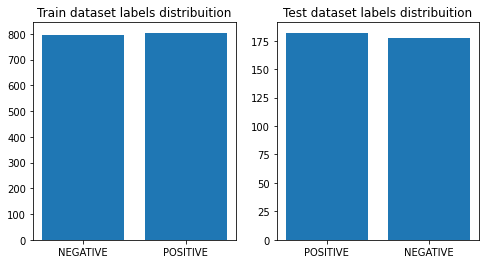

In [8]:
import tensorflow as tf

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, Conv1D, GRU, Bidirectional, MaxPool1D
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import os
import time
import pickle
import logging
import itertools
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

nltk.download('stopwords')

from google.colab import drive
drive.mount('/content/drive')

def downloader_to_gdrive(link, base_path, file_name, zip, chunk_size = 1000):
  path = base_path + file_name
  import os
  isdir = os.path.isdir(path[:-4])
  if isdir:
    print(file_name[:-4], "folder already exists! Download skipped...")
  else:
    isFile = os.path.isfile(path)
    if isFile:
      print(file_name, "already exists! Download skipped...")
    else:
      import requests
      r = requests.get(link, stream = True)
      # 1 MB = 1024 * 1024 byte
      CS = chunk_size*1024*1024
      with open(path, "wb") as file: 
        print(file_name, "download started.")
        for i, block in enumerate(r.iter_content(chunk_size = CS)):
          print(".", end = "")
          # print((i+1)*chunk_size,"MB downloaded...")
          if block:
            file.write(block)
        print("\n" + file_name, "download finished.")
    if zip:
      print("Extracting started...")
      import zipfile
      with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall(path[:-4])

base_path = "/content/drive/MyDrive/"

SDS_name = "sen.zip"
dataset_path = base_path + SDS_name
SDS_link =  "http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip"
downloader_to_gdrive(SDS_link, base_path, SDS_name, True, 1000)

# %%time
# READ DATASET:
dataset_utilize_percent = 0.001

DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

filenames = os.listdir(dataset_path[:-4])
te_df = pd.read_csv(dataset_path[:-4] + "/" + filenames[0], encoding =DATASET_ENCODING , names=DATASET_COLUMNS)
te_df = te_df.drop(['ids', 'date', 'flag', 'user'], axis = 1)
te_df = te_df[te_df.target != 2]
tr_df = pd.read_csv(dataset_path[:-4] + "/" + filenames[1], encoding =DATASET_ENCODING , names=DATASET_COLUMNS)
tr_df = tr_df.drop(['ids', 'date', 'flag', 'user'], axis = 1)

drop_indices = np.random.choice(tr_df.index, int((1-dataset_utilize_percent)*len(tr_df)), replace=False)
tr_df = tr_df.drop(drop_indices)

print("train dataset size:", len(tr_df))
print("test  dataset size:", len(te_df), "\n")


# Cleaning Section:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
def preprocess(text, stem=False):
  # Replace or remove links, mentions and special characters:
  # Remove mentions:
  TEXT_CLEANING_RE = "@\S+"
  # Rmove links:
  TEXT_CLEANING_RE += "|https?:\S+|http?:\S"
  # Remove any chars EXCEPT A-Z & a-z & 0-9:
  TEXT_CLEANING_RE += "|[^A-Za-z0-9]+"
  text = re.sub(TEXT_CLEANING_RE, " ", text.lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
        if stem:
            tokens.append(stemmer.stem(token))
        else:
            tokens.append(token)
  return " ".join(tokens)

# print("Row 1237, BEFORE CLEANING:", tr_df['text'][1237])
tr_df.text = tr_df.text.apply(lambda x: preprocess(x))
te_df.text = te_df.text.apply(lambda x: preprocess(x))
# print("Row 1237, AFTER  CLEANING:", tr_df['text'][1237], "\n")


# Mapper Section
def dataframe_mapper(df, col_name, from_l, to_l):
  for i in range(len(from_l)):
    df.loc[df[col_name] == from_l[i], col_name] = to_l[i]

# (0 = negative, 2 = neutral, 4 = positive)
target_labels = ["NEGATIVE", "POSITIVE"]

dataframe_mapper(tr_df, 'target', [0, 4], target_labels)
dataframe_mapper(te_df, 'target', [0, 4], target_labels)

train_target_cnt = Counter(tr_df.target)
plt.figure(1, figsize=(8,4))
plt.subplot(121)
plt.bar(train_target_cnt.keys(), train_target_cnt.values())
plt.title("Train dataset labels distribuition")
plt.subplot(122)
test_target_cnt = Counter(te_df.target)
plt.bar(test_target_cnt.keys(), test_target_cnt.values())
plt.title("Test dataset labels distribuition")
plt.show()

dataframe_mapper(tr_df, 'target', target_labels, [0, 1])
dataframe_mapper(te_df, 'target', target_labels, [0, 1])

     |████████████████████████████████| 4.9 MB 16.6 MB/s 
     |████████████████████████████████| 1.1 MB 29.3 MB/s 
     |████████████████████████████████| 1.2 MB 68.4 MB/s 
     |████████████████████████████████| 43 kB 2.6 MB/s 
     |████████████████████████████████| 596 kB 53.4 MB/s 
     |████████████████████████████████| 47.7 MB 1.2 MB/s 
     |████████████████████████████████| 99 kB 13.0 MB/s 
     |████████████████████████████████| 352 kB 68.7 MB/s 
     |████████████████████████████████| 1.1 MB 62.8 MB/s 
     |████████████████████████████████| 213 kB 77.9 MB/s 


2022-01-16 17:56:16,298 : INFO : Using /tmp/tfhub_modules to cache modules.
2022-01-16 17:56:16,337 : INFO : Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'.



TF Version:  2.7.0
Eager mode:  True
Hub version:  0.12.0


2022-01-16 17:56:23,052 : INFO : Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2, Total size: 421.50MB
2022-01-16 17:56:23,055 : INFO : Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'.



Set up tokenizer:
Vocab size: 30522

Tokenize ( Hello TensorFlow! I am Bert! Let's see what is going on here?! ):
['hello', 'tensor', '##flow', '!', 'i', 'am', 'bert', '!', 'let', "'", 's', 'see', 'what', 'is', 'going', 'on', 'here', '?', '!']
[7592, 23435, 12314, 999, 1045, 2572, 14324, 999, 2292, 1005, 1055, 2156, 2054, 2003, 2183, 2006, 2182, 1029, 999] 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 300)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 300)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)    

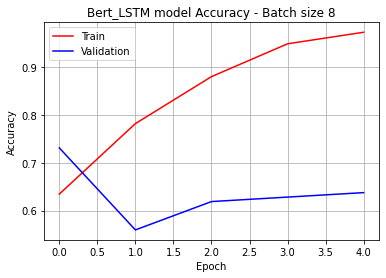


Plot the Accuracy Curves


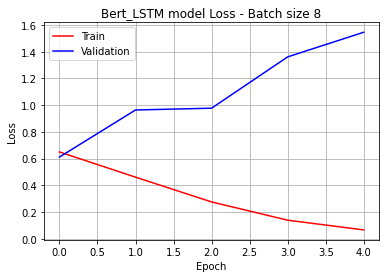


Confusion Matrix for Test dataset:


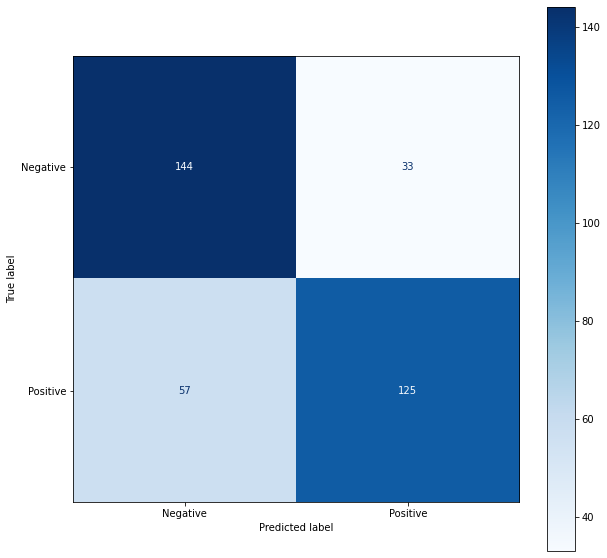

In [9]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
!pip install -q -U tensorflow-text
!pip install -q tf-models-official==2.4.0

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import tokenization
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import Input, layers, models, optimizers
from keras.models import load_model
tfds.disable_progress_bar()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import logging
logging.basicConfig(level=logging.INFO)

print("\nTF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)


# Set up epochs and steps
epochs = 5
valid_portion = 0.2
BATCH_SIZE = 8
max_sequence_len = 300
class_count = 2
class_label_names = ["Negative", "Positive"]

def pad_up_to(t, max_len, constant_values):
    paddings = [[0, 0], [0, max_len - tf.shape(t)[1]]]
    return tf.pad(t, paddings, 'CONSTANT', constant_values=constant_values)

def encode_sentence(s, tokenizer):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(texts, tokenizer, max_seq_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    sentence1 = tf.ragged.constant([encode_sentence(s, tokenizer) for s in np.array(texts)])
    # sentence2 = tf.ragged.constant([encode_sentence(s, tokenizer) for s in np.array(texts["sentence2"])])
    cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
    # input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)
    input_word_ids = tf.concat([cls, sentence1,], axis=-1)
    # The mask allows the model to cleanly differentiate between the content and the padding.
    # The mask has the same shape as the input_word_ids, and contains a 1 anywhere the input_word_ids is not padding.
    input_mask = tf.ones_like(input_word_ids).to_tensor()
    # The "input type" also has the same shape, but inside the non-padded region,
    # contains a 0 or a 1 indicating which sentence the token is a part of. 
    type_cls = tf.zeros_like(cls)
    type_s1 = tf.zeros_like(sentence1)
    # type_s2 = tf.ones_like(sentence2)
    # input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()
    input_type_ids = tf.concat([type_cls, type_s1,], axis=-1).to_tensor()
    input_word_ids = input_word_ids.to_tensor()
    pad_len = tf.shape(input_word_ids)
    input_mask = pad_up_to(input_mask, max_seq_len, 0)
    input_word_ids = pad_up_to(input_word_ids, max_seq_len, 0)
    input_type_ids = pad_up_to(input_type_ids, max_seq_len, 0)
    inputs = {'input_word_ids': input_word_ids, 'input_mask': input_mask, 'segment_ids': input_type_ids}
    return inputs

def build_bert_model(bert_layer, max_len=512):
    # Adding the inputs
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
    # Bert layer
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
    classifier_output = sequence_output[:, 0, :]
    # Softmax layer
    out = layers.Dense(2, activation='softmax')(classifier_output)
    # Finalize the model
    final_model = models.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=out)
    final_model.compile(optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    return final_model

# Uncased version changelog
# Version 4 : Support persistent gradient tapes.
# Version 3
#     Uses dicts (not lists) for inputs and outputs.
#     Comes with a companion model for preprocessing of plain text.
#     For legacy users, this version still provides the now-obsolete .vocab_file and .do_lower_case attributes on bert_layer.resolved_object. 
# Version 2
#     Fixes missing dropout. Previously, dropout was not applied when re-training the SavedModel, possibly resulting in a loss of quality.
#     Improves shape propagation. Applying the model to inputs of statically known max_seq_length now produces sequence_output with known dimension 1.
# Version 1 : Initial release.
ver = 2
uncased_module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/' + str(ver)
bert_layer = hub.KerasLayer(uncased_module_url, trainable=True)

# # Glue Dataset section:
# glue, info = tfds.load('glue/mrpc', with_info=True, batch_size=-1)
# print("\nDataset loaded.")
# print("\nKeys:")
# print(list(glue.keys()))
# print("\nDataset features:")
# print(info.features)
# print("\nClasses:")
# print(info.features['label'].names)

# Set up tokenizer to generate Tensorflow dataset
print("\nSet up tokenizer:")
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)
print("Vocab size:", len(tokenizer.vocab))

text_2B_tokenize = "Hello TensorFlow! I am Bert! Let's see what is going on here?!"
print("\nTokenize (", text_2B_tokenize, "):")
tokens = tokenizer.tokenize(text_2B_tokenize)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(tokens)
print(ids, "\n")

x_train = tr_df['text']
x_test = te_df['text']
x_train_en = bert_encode(x_train, tokenizer, max_sequence_len)
x_test_en = bert_encode(x_test, tokenizer, max_sequence_len)
y_train = tr_df['target']
y_test = te_df['target']
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=class_count)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=class_count)

# Creating the model:
bert_model = build_bert_model(bert_layer, max_len=max_sequence_len)
bert_model.summary()

model_name = "BERT_model"
model_dir = model_name + '.h5'
# checkpoint = tf.keras.callbacks.ModelCheckpoint(model_dir, monitor='val_accuracy', save_best_only=True, verbose=1)
# earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

train_history = bert_model.fit(x_train_en, y_train_one_hot, epochs=epochs, batch_size=BATCH_SIZE, validation_split=valid_portion, shuffle=True)

# Save the model:
bert_model.save(model_dir)  # creates a HDF5 file
# del model  # deletes the existing model

# bert_model.load_weights(model_dir)
# test_pred = bert_model.predict(x_test_en)

print("\nEvaluate model:")
score = bert_model.evaluate(x_test_en, y_test_one_hot, batch_size = BATCH_SIZE)
print("Test loss:", score[0])
print("Test accuracy:", score[1], "\n")

# plotting model performance
def model_plotter(model_history, metric, model_name, b_s):
    plt.figure()
    plt.plot(model_history.history[metric.lower()],'r')
    plt.plot(model_history.history['val_'+metric.lower()],'b')
    plt.title(model_name + ' model ' + metric.capitalize() + " - Batch size " + str(b_s))
    plt.ylabel(metric.capitalize())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.grid()
    plt.savefig(model_name + "_" + metric.lower() + "_" + str(b_s) + ".png")
    plt.show()

print("\nPlot the Accuracy Curves")
model_plotter(train_history, 'accuracy', "Bert_LSTM", BATCH_SIZE)

print("\nPlot the Accuracy Curves")
model_plotter(train_history, 'loss', "Bert_LSTM", BATCH_SIZE)

# decode score prediction from the model, to be 0 or 1
def decode_prediction(prediction):
  if prediction <= 0.5:
    return 'Negative'
  else:
    return 'Positive'

# Confusion Matrix
y_pred_softmax = bert_model.predict(x_test_en)
y_pred = [np.argmax(y) for y in y_pred_softmax]
cm = confusion_matrix(y_test.tolist(), y_pred)
plt.rcParams["figure.figsize"] = (10,10)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_label_names)
disp.plot(cmap=plt.cm.Blues)
print("\nConfusion Matrix for Test dataset:")
plt.show()
